<div class="alert alert-block alert-info">
    <h1>Análisis de Series Temporales</h1>
    <h3>Clase 8</h3>
    <h3>Ejercicio 1_Prophet & Neural Prophet - DART</h3>
        <p>Docente: Rodrigo Del Rosso<p>
        <p>Asistentes: Sebastián Calcagno, Braian Drago <p>
</div>

**Prophet  o Facebook Prophet (2017) es el predecesor de NeuralProphet (2020)**

La principal diferencia entre Prophet y NeuralProphet radica en la técnica subyacente utilizada para el pronóstico. Prophet utiliza un enfoque basado en componentes (Utiliza un enfoque aditivo para descomponer una serie temporal en tres componentes principales: tendencia, estacionalidad y días festivos), mientras que NeuralProphet emplea redes neuronales para capturar patrones más complejos y no lineales en los datos de series temporales. Neural Prophet incorpora términos de aprendizaje profundo a nuestra ecuación que se ajustan a datos autorregresivos (retrasados)

*Algunos artículos de interes:*

https://blog.ml6.eu/is-neuralprophet-better-than-prophet-for-sales-forecasting-de45527163dc  

https://dataamber.medium.com/neural-prophet-vs-prophet-why-neural-prophet-is-so-accurate-60fe1313ac05#:~:text=Compared%20with%20the%20traditional%20AR,willing%20to%20use%20it%20everywhere.

In [ ]:
# Se instalan las librerías
#!pip install pandas-profiling #==2.7.1
#!pip install darts
!pip install seaborn
!pip install pmdarima
!pip install pystan
!pip install prophet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 MB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 59.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 5.3 MB/s eta 0:00:00


In [ ]:
# Se cargan las librerías
from pandas import DataFrame
from pandas import concat
import random
from scipy import stats
import numpy as np
import pandas as pd
from math import sqrt
from numpy import concatenate
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from pandas import DataFrame
from pandas import concat
import seaborn as sn
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import gc
from IPython.display import YouTubeVideo
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import auto_arima
#from darts import TimeSeries
import pmdarima as pm
#from darts.models import (NaiveSeasonal,NaiveDrift,RNNModel,Prophet,ExponentialSmoothing,ARIMA,AutoARIMA,TCNModel,TransformerModel,Theta,FFT)
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# **Ejemplo Dataset Air Passengers**

[Fuente del Dataset](https://www.kaggle.com/rakannimer/air-passengers)

Este conjunto de datos proporciona totales mensuales de pasajeros de una aerolínea estadounidense desde 1949 hasta 1960.

## **Análisis Exploratorio**

Fuentes de los desarrollos:  
[Ejemplo1](https://www.kaggle.com/manas13/time-series-air-passenger)  
[Ejemplo 2](https://www.kaggle.com/harshitmakkar/univariate-time-series-analysis-arima-and-sarima)

In [ ]:
custom_date_parser = lambda dates: pd.datetime.strptime(dates, '%Y-%m')
#custom_date_parser = lambda dates: pd.datetime.strptime(dates, '%Y-%D-%m')
url='https://raw.githubusercontent.com/braiandrago/AST/main/AirPassengers.csv'
df = pd.read_csv(url,parse_dates = ['Month'],index_col='Month',date_parser = custom_date_parser);
df.head(15)

#Passengers
Month                  
1949-01-01          112
1949-02-01          118
1949-03-01          132
1949-04-01          129
1949-05-01          121
1949-06-01          135
1949-07-01          148
1949-08-01          148
1949-09-01          136
1949-10-01          119
1949-11-01          104
1949-12-01          118
1950-01-01          115
1950-02-01          126
1950-03-01          141

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   #Passengers  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


Repasemos los parámetros en el código read_csv anterior:

**parse_dates:** le dice que analicen la columna especificada como fecha.

**index_col:** especifica qué columna usar como índice. Al analizar series de tiempo en Pandas, es importante que la variable que contiene la información de tiempo se use como índice.

**date_parser:** especifica cómo analizar la fecha. Por defecto, pandas usa el formato 'AAAA-MM-DD HH: MM: SS'. Entonces, si la fecha que queremos analizar no está en este formato, necesitamos definir un formato personalizado.

In [ ]:
# Se convierte el dataframe a una serie de tiempo
ts = df['#Passengers']
ts.head()

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Name: #Passengers, dtype: int64

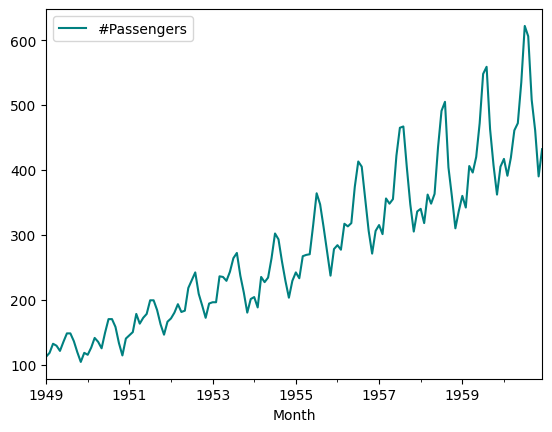

In [ ]:
# Se grafica la serie
df.plot(color='teal');

Vemos que la serie tiene una clara tendencia y estacionalidad

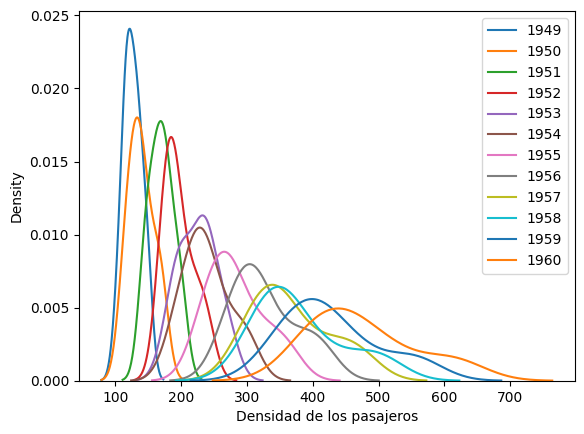

In [ ]:
# Se grafica la densidad de los pasajeros para los distintos años
df = pd.read_csv(url, parse_dates=['Month'], index_col='Month')
df.reset_index(inplace=True)

df['year'] = [d.year for d in df.Month]
df['month'] = [d.strftime('%b') for d in df.Month]
years = df['year'].unique()
df.groupby('year')['#Passengers'].apply(lambda x: sn.distplot(x,
        hist=False, rug=False,label = x.name));
plt.legend()
plt.xlabel('Densidad de los pasajeros');

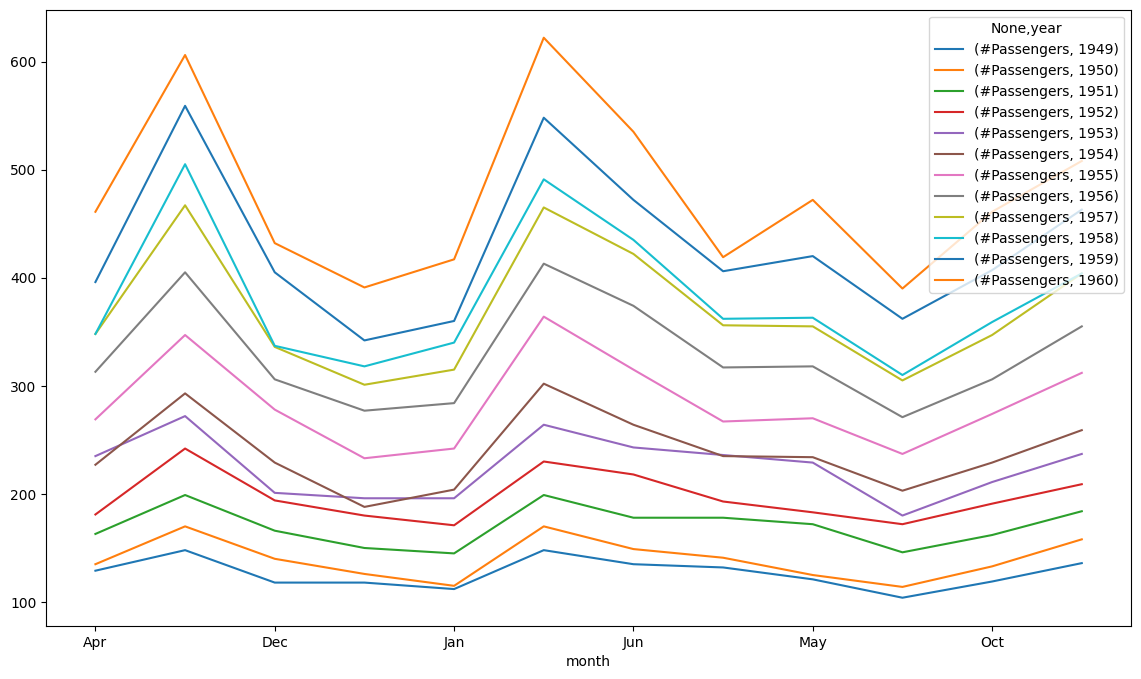

In [ ]:
# Evolución de los pasajeros por año
piv = pd.pivot_table(df ,index=['month'],columns=['year'], values=['#Passengers'])
piv.plot(figsize=(14,8));

In [ ]:
piv

#Passengers                                                       
year         1949 1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960
month                                                                   
Apr           129  135  163  181  235  227  269  313  348  348  396  461
Aug           148  170  199  242  272  293  347  405  467  505  559  606
Dec           118  140  166  194  201  229  278  306  336  337  405  432
Feb           118  126  150  180  196  188  233  277  301  318  342  391
Jan           112  115  145  171  196  204  242  284  315  340  360  417
Jul           148  170  199  230  264  302  364  413  465  491  548  622
Jun           135  149  178  218  243  264  315  374  422  435  472  535
Mar           132  141  178  193  236  235  267  317  356  362  406  419
May           121  125  172  183  229  234  270  318  355  363  420  472
Nov           104  114  146  172  180  203  237  271  305  310  362  390
Oct           119  133  162  191  211  229  274  306  347  359  407  461
Sep           136  158  184  209  237  259  312  355  404  404  463  508

In [ ]:
# Reordenar los índices para que los meses aparezcan en orden cronológico
meses_ordenados = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
piv = piv.reindex(meses_ordenados)

In [ ]:
piv

#Passengers                                                       
year         1949 1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960
month                                                                   
Jan           112  115  145  171  196  204  242  284  315  340  360  417
Feb           118  126  150  180  196  188  233  277  301  318  342  391
Mar           132  141  178  193  236  235  267  317  356  362  406  419
Apr           129  135  163  181  235  227  269  313  348  348  396  461
May           121  125  172  183  229  234  270  318  355  363  420  472
Jun           135  149  178  218  243  264  315  374  422  435  472  535
Jul           148  170  199  230  264  302  364  413  465  491  548  622
Aug           148  170  199  242  272  293  347  405  467  505  559  606
Sep           136  158  184  209  237  259  312  355  404  404  463  508
Oct           119  133  162  191  211  229  274  306  347  359  407  461
Nov           104  114  146  172  180  203  237  271  305  310  362  390
Dec           118  140  166  194  201  229  278  306  336  337  405  432

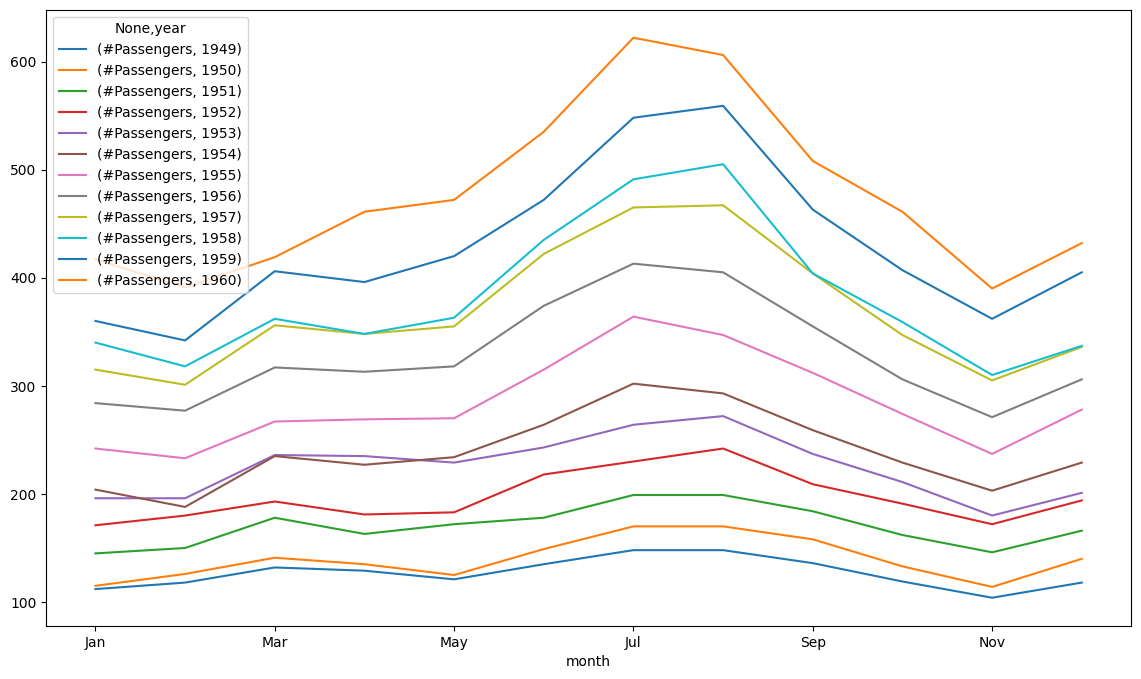

In [ ]:
piv.plot(figsize=(14,8));

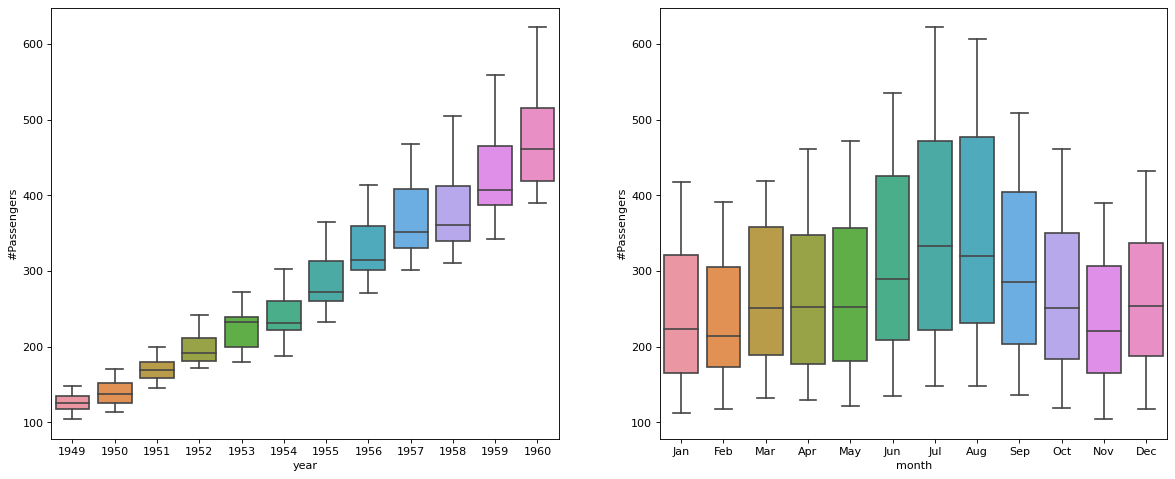

In [ ]:
# Box plot de la cantidad de pasajeros por año y por mes
fig, axes = plt.subplots(1, 2, figsize=(18,7), dpi= 80)
sn.boxplot(x='year', y='#Passengers', data=df, ax=axes[0]);
sn.boxplot(x='month', y='#Passengers', data=df);

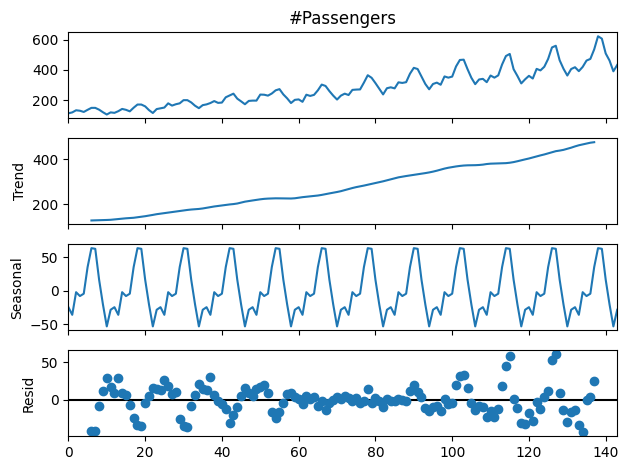

In [ ]:
# Descomposición aditiva de la serie
airpax_decompose = sm.tsa.seasonal_decompose(df['#Passengers'], model="additive", period=12)
airpax_decompose.plot()
plt.show()

**Chequeo de Estacionariedad:**

Se dice que una serie temporal es estacionaria si lo siguiente es cierto:

1.   Media constante
2.   Varianza constante
3.   Autocovarianza que no depende del tiempo.

Pero, ¿por qué deberíamos preocuparnos por la estacionariedad? La mayoría de los métodos estadísticos utilizados en el análisis de series de tiempo asumen que la serie es estacionaria. Además, tener una serie estacionaria tiene una ventaja práctica ya que significaría que el comportamiento promedio de la serie será el mismo en el futuro. Por lo tanto, podemos hacer predicciones. Se corroborará la estacionariedad:

In [ ]:
# Test de Dickey-Fuller
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
test_stationarity(ts)

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


La serie no es estacionaria porque:

*   El p-value es mayor que el nivel de confianza típico de 0.05, por lo que no rechazamos la hipótesis nula (existe una raíz unitaria).
*   Los valores críticos de la prueba Dickey-Fuller son mucho más grandes que los estadísticos de la prueba.





In [ ]:
# Se define la función de autocorrelación y autocorrelación parcial
lag_acf  = acf(ts.dropna(inplace=False), nlags=20)
lag_pacf = pacf(ts.dropna(inplace=False), nlags=20)

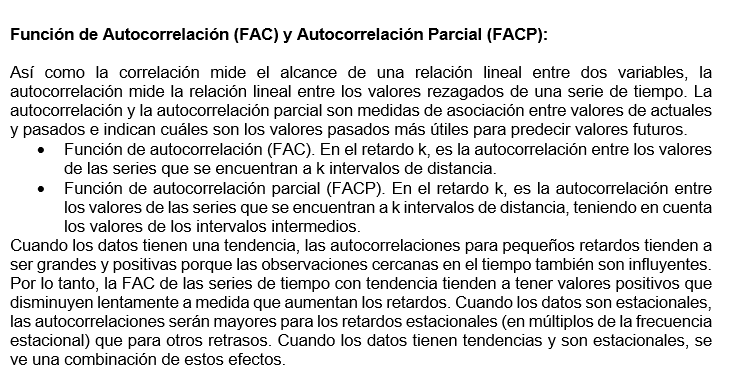

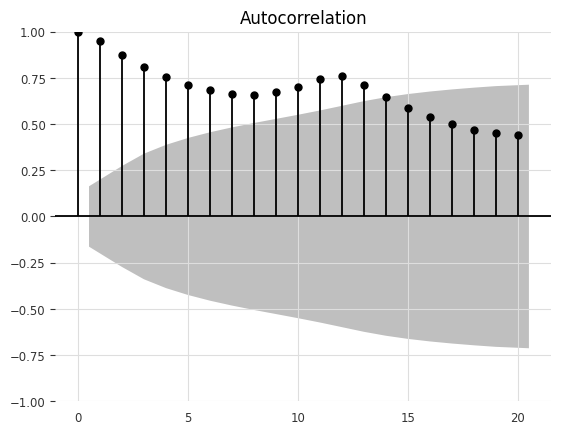

In [ ]:
lags = 20
# acf
a=plot_acf(ts.dropna(inplace=False), lags=lags)

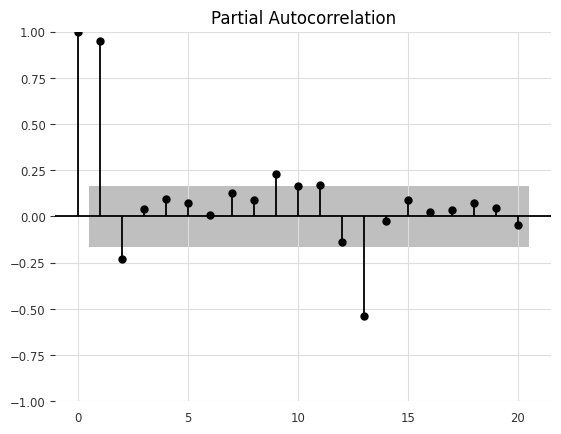

In [ ]:
#pacf
b=plot_pacf(ts.dropna(inplace=False),lags=lags)

Para convertir la serie temporal en estacionaria se debe eliminar la tendencia y estacionalidad. Una forma de realizar esto es mediante la diferenciación.

In [ ]:
# Equivalente del ndiffs y nsdiffs de R (ver: http://alkaline-ml.com/pmdarima/1.5.1/modules/classes.html#differencing-helpers)
print(pm.arima.ndiffs(ts))
print(pm.arima.nsdiffs(ts,m=12))

1
1


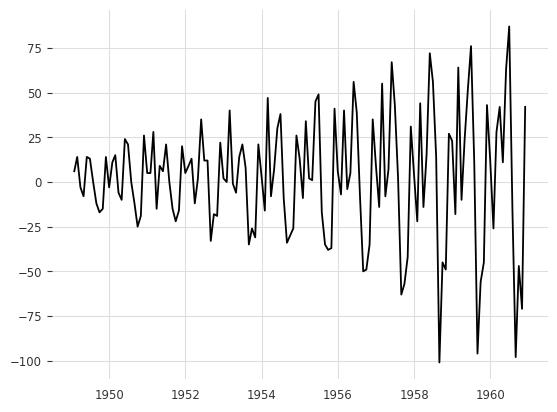

Results of Dickey-Fuller Test:
Test Statistic                  -2.829267
p-value                          0.054213
#Lags Used                      12.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [ ]:
# Se diferencia la serie 1 período
nonseasonal_diff = ts.diff(periods=1)
plt.plot(nonseasonal_diff)
plt.show()
test_stationarity(nonseasonal_diff.dropna(inplace=False))

La serie sigue siendo no estacionaria

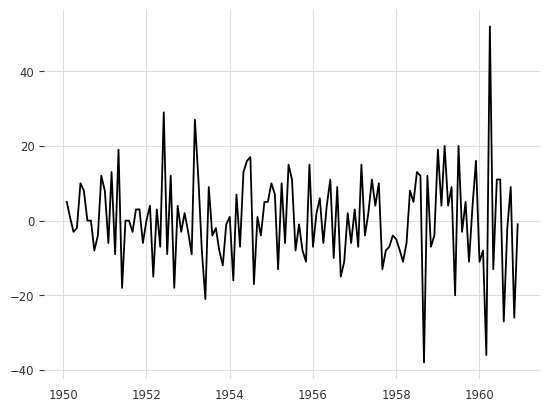

Results of Dickey-Fuller Test:
Test Statistic                -1.559562e+01
p-value                        1.856512e-28
#Lags Used                     0.000000e+00
Number of Observations Used    1.300000e+02
Critical Value (1%)           -3.481682e+00
Critical Value (5%)           -2.884042e+00
Critical Value (10%)          -2.578770e+00
dtype: float64


In [ ]:
# Se diferencia la serie 12 períodos
seasonal_diff = nonseasonal_diff.diff(periods=12)
plt.plot(seasonal_diff)
plt.show()
test_stationarity(seasonal_diff.dropna(inplace=False))

La serie es estacionaria

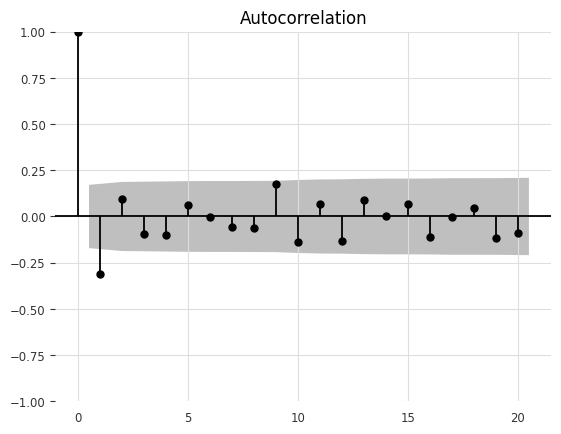

In [ ]:
a=plot_acf(seasonal_diff.dropna(inplace=False), lags=20)

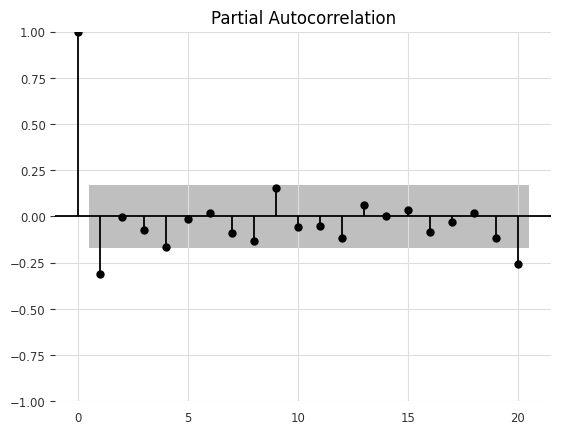

In [ ]:
b=plot_pacf(seasonal_diff.dropna(inplace=False),lags=lags)

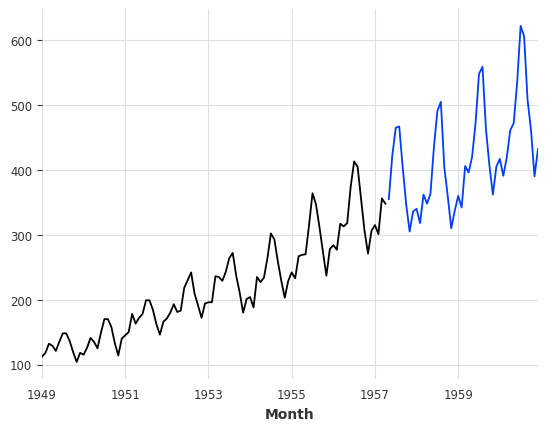

In [ ]:
# Se divide en entranamiento (70%) y testeo (30%)
train = ts[:int(0.7*(len(df)))]
test = ts[int(0.7*(len(df))):]

# Se grafican ambos conjuntos de datos
ax = train.plot()
test.plot(ax=ax);

# **Se dessarrollan algunos modelos tradicionales para luego comparar los resultados:**

## **ARIMA**
[Teoría ARIMA](https://bookdown.org/amanas/traficomadrid/m%C3%A9todos-param%C3%A9tricos.html#m%C3%A9todo-arima)

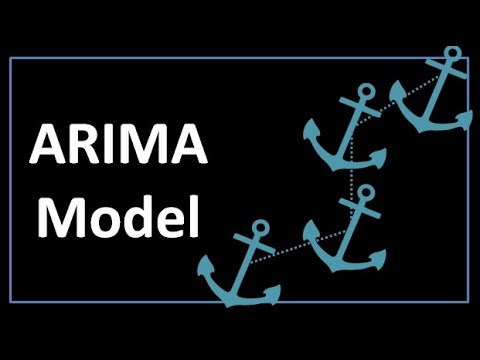

In [ ]:
YouTubeVideo('3UmyHed0iYE')
# https://www.youtube.com/watch?v=3UmyHed0iYE

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.06 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=909.769, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=907.370, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=904.979, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=908.785, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=900.136, Time=0.32 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.89 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.67 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.52 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=904.858, Time=0.23 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=898.911, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=903.548, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=906.025, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=896.369, Time=0.13 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=903.746, Time=0.07 se

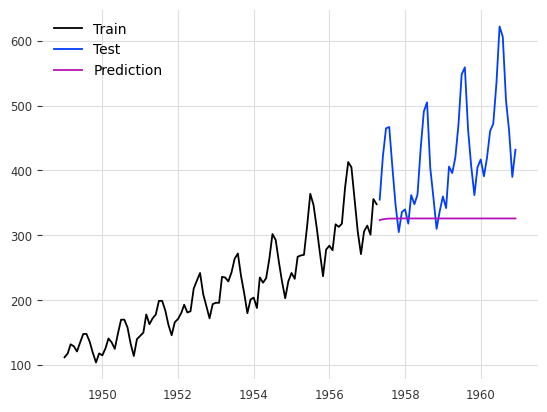

In [ ]:
# Se construye el modelo ARIMA
df = pd.read_csv(url,parse_dates = ['Month'],index_col='Month',date_parser = custom_date_parser)
train = df[:int(0.7*(len(df)))]
test = df[int(0.7*(len(df))):]

model = auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train)

forecast = model.predict(n_periods=len(test))
forecast = pd.DataFrame(forecast,index = test.index,columns=['Prediction'])

# Se grafican las bases de entrenamiento, testeo y las predicciones
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(forecast, label='Prediction')
plt.legend(loc='best')
plt.show()

In [ ]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:               SARIMAX(1, 1, 2)   Log Likelihood                -443.946
Date:                Sun, 22 Oct 2023   AIC                            895.892
Time:                        12:25:38   BIC                            906.272
Sample:                    01-01-1949   HQIC                           900.092
                         - 04-01-1957                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4654      0.133      3.489      0.000       0.204       0.727
ma.L1         -0.2326      0.141     -1.653      0.098      -0.508       0.043
ma.L2         -0.5172      0.099     -5.224      0.000      -0.711      -0.323
sigma2       456.8414     83.534      5.469      0.000     293.118     620.565
===================================================================================
Ljung-Box (L1) (Q):                   0.48   Jarque-Bera (JB):                 3.74
Prob(Q):                              0.49   Prob(JB):                         0.15
Heteroskedasticity (H):               3.72   Skew:                             0.31
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
# Cálculo de las medidas de precisión
rmse = sqrt(mean_squared_error(test, forecast))
print('Test RMSE: %.3f' % rmse)
mse = mean_squared_error(test, forecast)
print('Test MSE: %.3f' % mse)
mae = mean_absolute_error(test, forecast)
print('Test MAE: %.3f' % mae)
r2 = r2_score(test, forecast)
print('Test R2: %.3f' % r2)

Test RMSE: 122.024
Test MSE: 14889.769
Test MAE: 97.192
Test R2: -1.548


## SARIMA
[Teoría SARIMA](https://bookdown.org/amanas/traficomadrid/m%C3%A9todos-param%C3%A9tricos.html#m%C3%A9todo-sarima---arima-estacional)

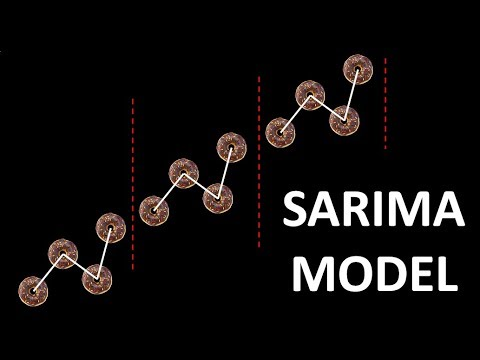

In [ ]:
YouTubeVideo('WjeGUs6mzXg')
# https://www.youtube.com/watch?v=WjeGUs6mzXg

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=647.761, Time=0.88 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=650.796, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=644.203, Time=0.16 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=644.733, Time=0.21 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=645.995, Time=0.06 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=646.172, Time=0.54 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=646.187, Time=0.70 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=644.600, Time=0.51 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=4.37 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=647.442, Time=0.26 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=646.085, Time=0.49 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=645.647, Time=0.57 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=644.346, Time=0.39 sec
 ARIMA(2,1,1)(1,1,0)[12]             : AIC=647.580, Time=0.78 sec
 ARIMA(1,1,0)(1,1,0)[12] intercept   

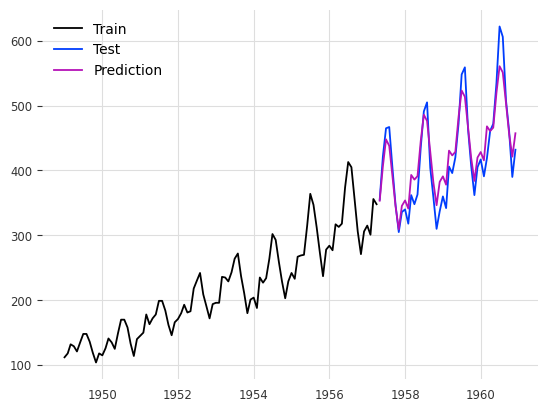

In [ ]:
# Se construye el modelo SARIMA
df = pd.read_csv(url,parse_dates = ['Month'],index_col='Month',date_parser = custom_date_parser)
train = df[:int(0.7*(len(df)))]
test = df[int(0.7*(len(df))):]

from pmdarima.arima import auto_arima
model = auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True,seasonal=True,m=12,D=1) #Seasonal=True hace al modelo SARIMA
model.fit(train)

forecast = model.predict(n_periods=len(test))
forecast = pd.DataFrame(forecast,index = test.index,columns=['Prediction'])

# Se grafican las bases de entrenamiento, testeo y las predicciones
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(forecast, label='Prediction')
plt.legend(loc='best')
plt.show()

In [ ]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  100
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -319.101
Date:                            Sun, 22 Oct 2023   AIC                            644.203
Time:                                    12:28:05   BIC                            651.601
Sample:                                01-01-1949   HQIC                           647.182
                                     - 04-01-1957                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2434      0.097     -2.512      0.012      -0.433      -0.054
ar.S.L12      -0.2127      0.087     -2.432      0.015      -0.384      -0.041
sigma2        89.1842     14.080      6.334      0.000      61.587     116.781
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 2.43
Prob(Q):                              0.97   Prob(JB):                         0.30
Heteroskedasticity (H):               1.32   Skew:                             0.40
Prob(H) (two-sided):                  0.46   Kurtosis:                         2.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

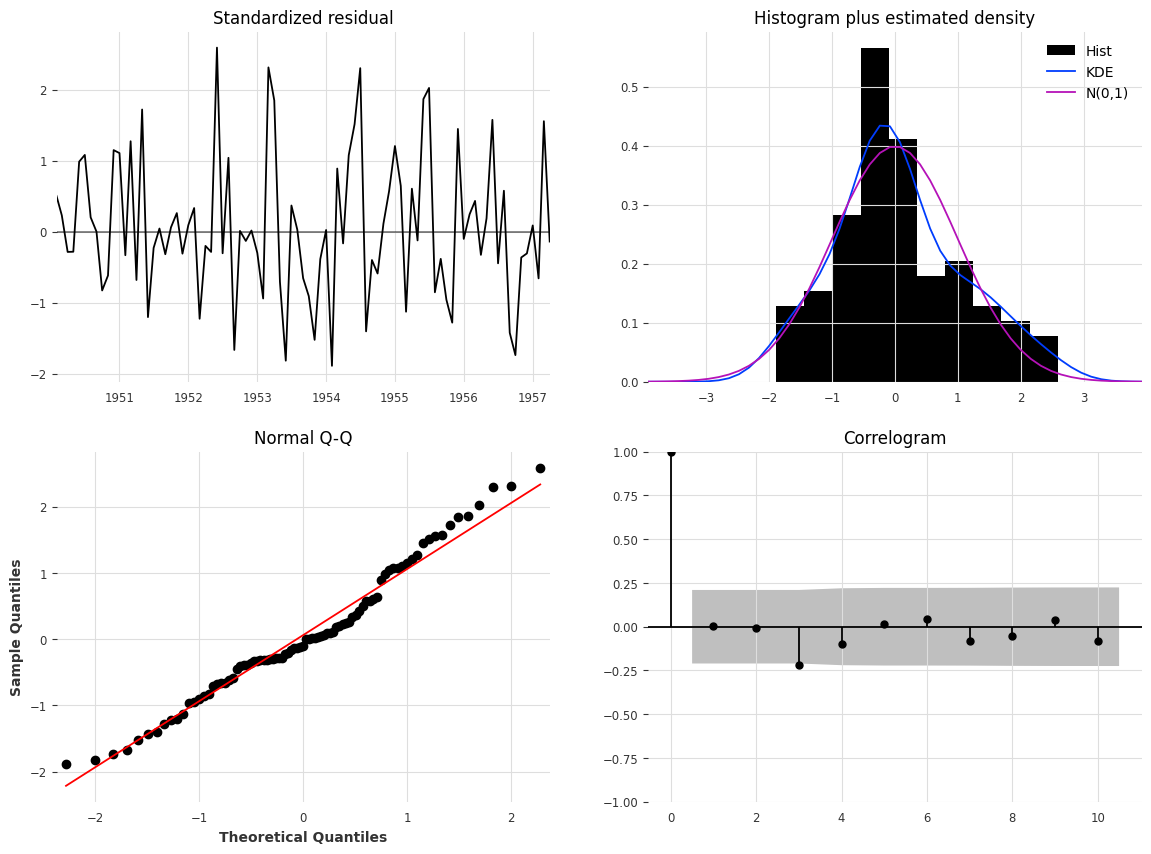

In [ ]:
model.plot_diagnostics(figsize=(14,10))
plt.show()

In [ ]:
# Cálculo de las medidas de precisión
rmse = sqrt(mean_squared_error(test, forecast))
print('Test RMSE: %.3f' % rmse)
mse = mean_squared_error(test, forecast)
print('Test MSE: %.3f' % mse)
mae = mean_absolute_error(test, forecast)
print('Test MAE: %.3f' % mae)
r2 = r2_score(test, forecast)
print('Test R2: %.3f' % r2)

Test RMSE: 26.206
Test MSE: 686.748
Test MAE: 21.539
Test R2: 0.882


## **Prophet o Facebook Prophet**
[Página Oficial](https://facebook.github.io/prophet/) [Fuente del Ejemplo](https://www.kaggle.com/prashant111/tutorial-time-series-forecasting-with-prophet?scriptVersionId=50165664)  

https://facebook.github.io/prophet/docs/installation.html#python

https://cran.r-project.org/web/packages/prophet/prophet.pdf

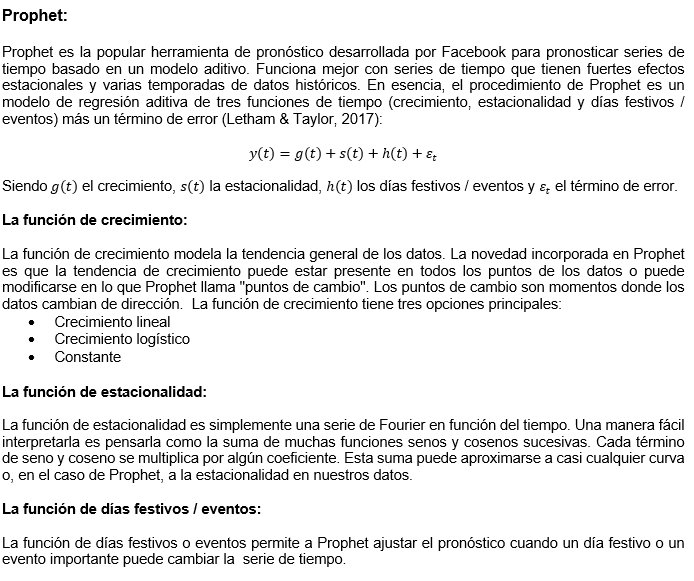

**Carga de datos:**

In [ ]:
# Se carga la base
df = pd.read_csv(url)
df['Month'] = pd.to_datetime(df['Month'])
df.head()

Month  #Passengers
0 1949-01-01          112
1 1949-02-01          118
2 1949-03-01          132
3 1949-04-01          129
4 1949-05-01          121

La entrada a Prophet es siempre un dataframe con dos columnas: **ds** e **y**.

La columna **ds** (date stamp) debe tener el formato usado por Pandas, idealmente AAAA-MM-DD para una fecha o AAAA-MM-DD HH: MM: SS para tiempo.

La columna **y** debe ser numérica y representa la medida que deseamos pronosticar.

In [ ]:
# Se redefinen las variables para poder aplicar la librería Prophet
df = df.rename({'Month':'ds','#Passengers':'y'}, axis='columns')
df.head()

ds    y
0 1949-01-01  112
1 1949-02-01  118
2 1949-03-01  132
3 1949-04-01  129
4 1949-05-01  121

In [ ]:
# Se define la base de entrenamiento (70%) y testeo (30%)
train = df[:int(0.7*(len(df)))]
test = df[int(0.7*(len(df))):]
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44 entries, 100 to 143
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      44 non-null     datetime64[ns]
 1   y       44 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 836.0 bytes


In [ ]:
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot

**Default Prophet**

In [ ]:
# Se inicializa y entrena el modelo
# Se define el intervalo de confianza en 95% (el valor por default es 80%)
m = Prophet(interval_width=0.95)
m.fit(train)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyps7l9k7/gk2iia59.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyps7l9k7/78yszepb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60607', 'data', 'file=/tmp/tmpyps7l9k7/gk2iia59.json', 'init=/tmp/tmpyps7l9k7/78yszepb.json', 'output', 'file=/tmp/tmpyps7l9k7/prophet_model2p9n5bjv/prophet_model-20231121214209.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:42:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:42:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
# Se define la cantidad de períodos a predecir. 44 equivale a la base de testeo
future = m.make_future_dataframe(periods=44, freq='MS')

En el parámetro freq se define la frecuencia mensual (MS) para las predicciones

In [ ]:
# Se generan las predicciones
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds        yhat  yhat_lower  yhat_upper
139 1960-08-01  522.032293  493.781591  547.301023
140 1960-09-01  490.316917  462.955073  517.165375
141 1960-10-01  463.482742  436.349485  492.644401
142 1960-11-01  440.146055  411.711727  468.325972
143 1960-12-01  465.638196  438.264039  492.494986

*   yhat: es la predicción
*   yhat_lower: es el límite inferior de la predicción
*   yhat_upper: es el límite superior de la predicción

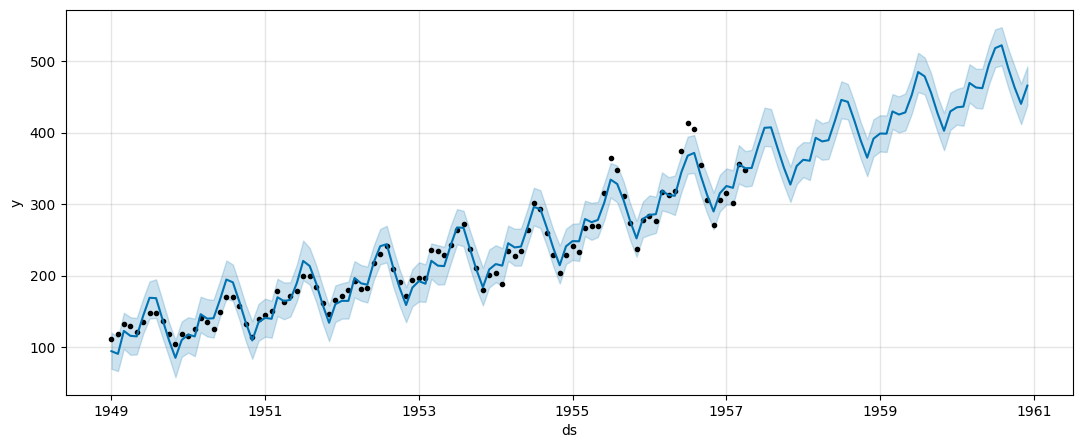

In [ ]:
# Se grafican las predicciones (línea) y la base de entranamiento (puntos)
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(13)
fig = m.plot(forecast,ax=ax)
plt.show()

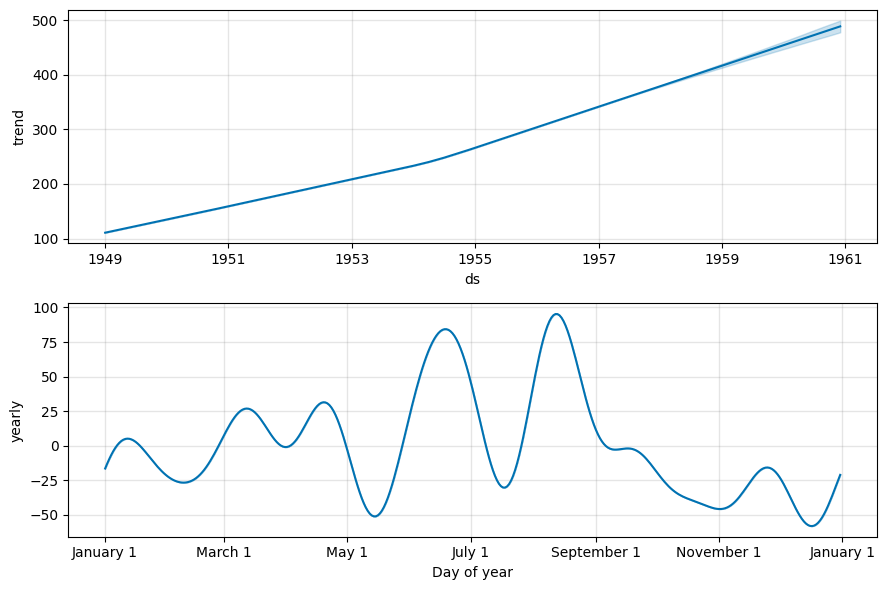

In [ ]:
# Se grafican las componenestes de las predicciones
fig2 = m.plot_components(forecast)

Estos gráficos muestran que la tendencia de pasajeros es creciente con los años y que los meses de más tráfico son los de las vacaciones de Julio y Agosto

In [ ]:
# Configuración para obtener gráficos interactivos
from plotly.offline import iplot, init_notebook_mode
import plotly.graph_objs as go

In [ ]:
def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))

In [ ]:
from prophet.plot import plot_plotly, plot_components_plotly

In [ ]:
#import plotly.express as px
configure_plotly_browser_state()
init_notebook_mode(connected=False)
fig = plot_plotly(m, forecast) # Replace with your own data
fig.show()

In [ ]:
# Se grafican las componentes de las predicciones
configure_plotly_browser_state()
init_notebook_mode(connected=False)
fig = plot_components_plotly(m, forecast)
fig.show()


Los puntos de cambio son aquellos momentos donde la serie tiene un cambio abrupto en su trayectoria. Por default Prophet agrega 25 puntos de cambio al 80% del conjunto de datos.

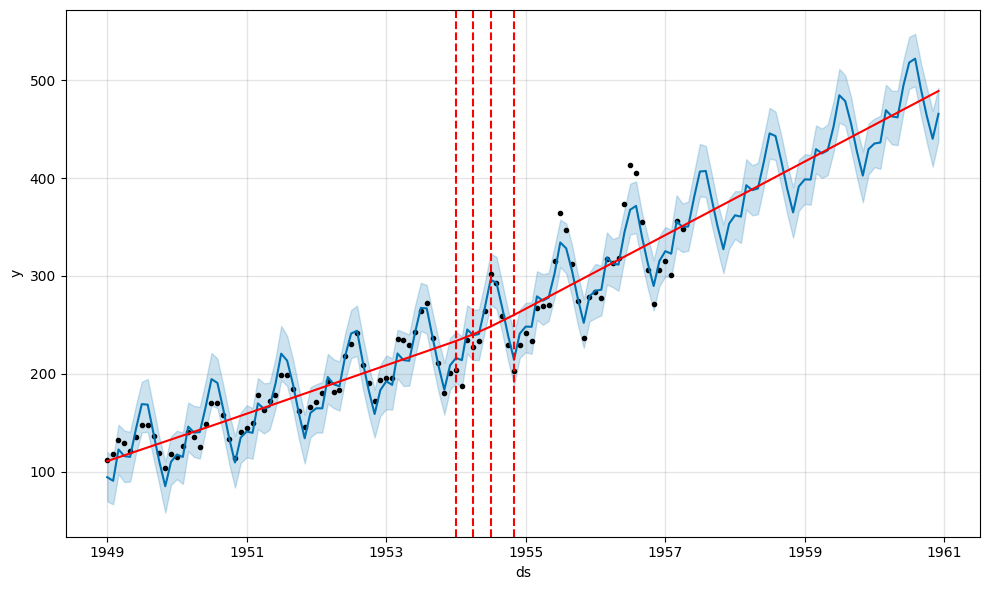

In [ ]:
# Se grafican los puntos de cambio
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

In [ ]:
m.changepoints

3    1949-04-01
6    1949-07-01
9    1949-10-01
13   1950-02-01
16   1950-05-01
19   1950-08-01
22   1950-11-01
25   1951-02-01
28   1951-05-01
32   1951-09-01
35   1951-12-01
38   1952-03-01
41   1952-06-01
44   1952-09-01
47   1952-12-01
51   1953-04-01
54   1953-07-01
57   1953-10-01
60   1954-01-01
63   1954-04-01
66   1954-07-01
70   1954-11-01
73   1955-02-01
76   1955-05-01
79   1955-08-01
Name: ds, dtype: datetime64[ns]

In [ ]:
# Se generan las predicciones para la base de testeo
X_tst_forecast = m.predict(test)
X_tst_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds        yhat  yhat_lower  yhat_upper
39 1960-08-01  522.032293  497.252287  547.692020
40 1960-09-01  490.316917  462.444073  517.675963
41 1960-10-01  463.482742  436.113851  491.934863
42 1960-11-01  440.146055  412.495886  466.638198
43 1960-12-01  465.638196  437.854881  493.498335

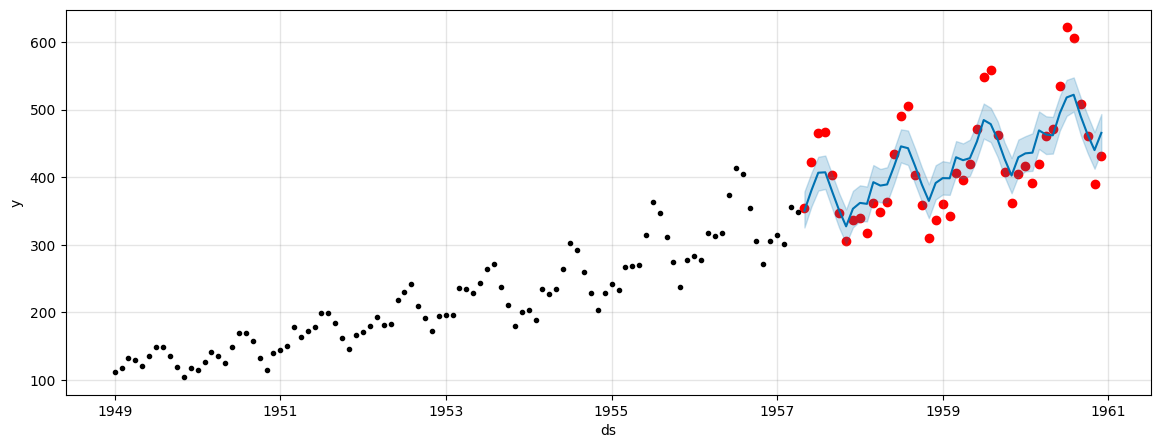

In [ ]:
# Se grafican la base de entrenamiento (punteado negro), la de testeo (punteado rojo) y las predicciones (azul)
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(14)
ax.scatter(test.ds, test['y'], color='r')
fig = m.plot(X_tst_forecast, ax=ax)

In [ ]:
# Cálculo de las medidas de precisión
rmse = sqrt(mean_squared_error(test['y'], X_tst_forecast['yhat']))
print('Test RMSE: %.3f' % rmse)
mse = mean_squared_error(test['y'], X_tst_forecast['yhat'])
print('Test MSE: %.3f' % mse)
mae = mean_absolute_error(test['y'], X_tst_forecast['yhat'])
print('Test MAE: %.3f' % mae)
r2 = r2_score(test['y'], X_tst_forecast['yhat'])
print('Test R2: %.3f' % r2)

Test RMSE: 41.872
Test MSE: 1753.306
Test MAE: 35.060
Test R2: 0.700


**Holidays**

https://facebook.github.io/prophet/docs/seasonality,_holiday_effects,_and_regressors.html#modeling-holidays-and-special-events

In [ ]:
# Python
dias_feriados = pd.DataFrame({
  'holiday': 'Mantenimiento',
  'ds': pd.to_datetime(['1949-09-01', '1950-09-01', '1951-08-01','1951-09-01',
                        '1952-09-01', '1953-09-01', '1954-09-01', '1955-09-01', '1956-08-01','1956-09-01',
                        '1957-09-01', '1958-09-01', '1959-09-01', '1960-09-01'])
})

In [ ]:
dias_feriados

holiday         ds
0   Mantenimiento 1949-09-01
1   Mantenimiento 1950-09-01
2   Mantenimiento 1951-08-01
3   Mantenimiento 1951-09-01
4   Mantenimiento 1952-09-01
5   Mantenimiento 1953-09-01
6   Mantenimiento 1954-09-01
7   Mantenimiento 1955-09-01
8   Mantenimiento 1956-08-01
9   Mantenimiento 1956-09-01
10  Mantenimiento 1957-09-01
11  Mantenimiento 1958-09-01
12  Mantenimiento 1959-09-01
13  Mantenimiento 1960-09-01

In [ ]:
m = Prophet(interval_width=0.95,holidays=dias_feriados)
m.fit(train)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyps7l9k7/3zneoxe2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyps7l9k7/eosididu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63363', 'data', 'file=/tmp/tmpyps7l9k7/3zneoxe2.json', 'init=/tmp/tmpyps7l9k7/eosididu.json', 'output', 'file=/tmp/tmpyps7l9k7/prophet_modelzgd98b0e/prophet_model-20231121214630.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:46:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:46:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
# Python
forecast = forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds        yhat  yhat_lower  yhat_upper
139 1960-08-01  518.263215  490.651873  546.120920
140 1960-09-01  489.786624  464.475899  518.995727
141 1960-10-01  462.964241  436.476416  490.078742
142 1960-11-01  439.654441  412.131545  466.915686
143 1960-12-01  465.164338  438.527740  493.309871

In [ ]:
# Se generan las predicciones para la base de testeo
X_tst_forecast = m.predict(test)
X_tst_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds        yhat  yhat_lower  yhat_upper
39 1960-08-01  518.263215  492.102887  544.828266
40 1960-09-01  489.786624  463.262915  515.864377
41 1960-10-01  462.964241  436.758380  488.973735
42 1960-11-01  439.654441  411.838450  468.318019
43 1960-12-01  465.164338  437.545607  491.172101

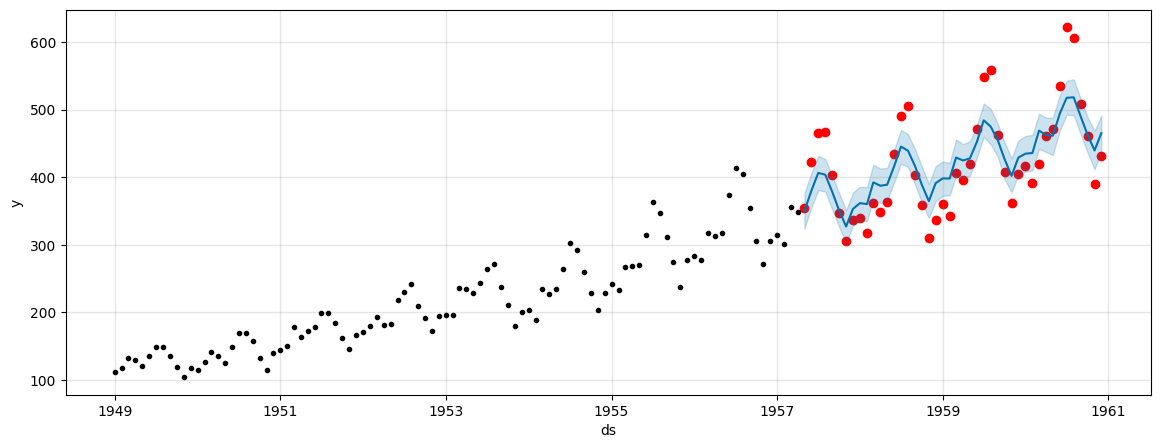

In [ ]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(14)
ax.scatter(test.ds, test['y'], color='r')
fig = m.plot(X_tst_forecast, ax=ax)

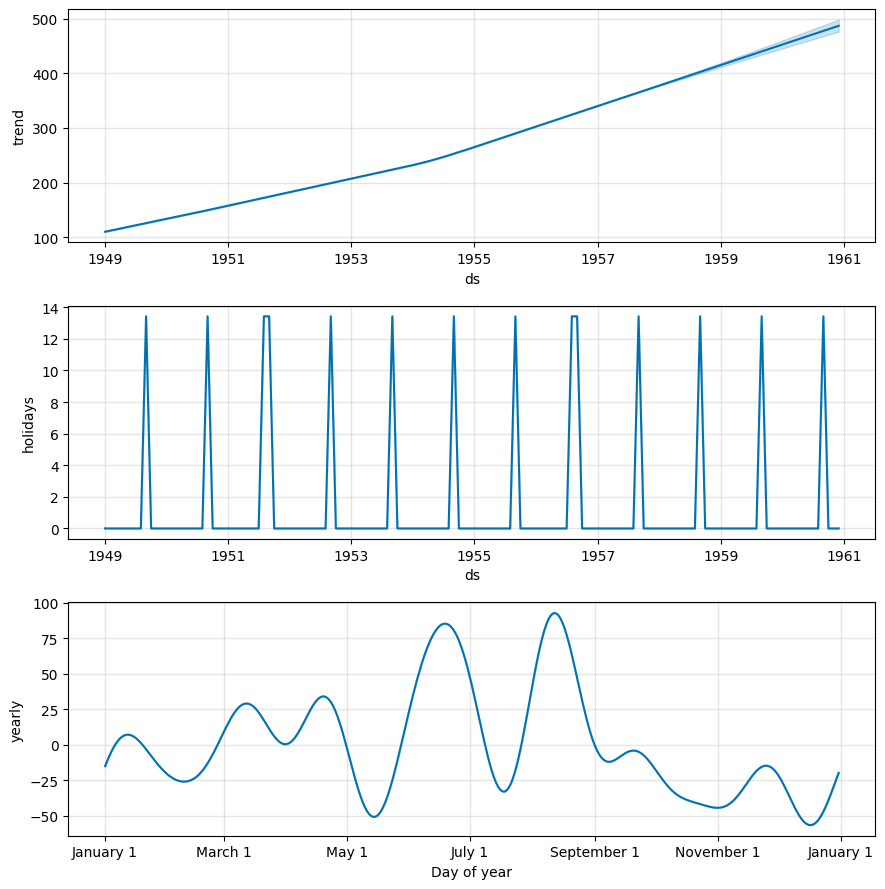

In [ ]:
fig = m.plot_components(forecast)

In [ ]:
rmse = sqrt(mean_squared_error(test['y'], X_tst_forecast['yhat']))
print('Test RMSE: %.3f' % rmse)
mse = mean_squared_error(test['y'], X_tst_forecast['yhat'])
print('Test MSE: %.3f' % mse)
mae = mean_absolute_error(test['y'], X_tst_forecast['yhat'])
print('Test MAE: %.3f' % mae)
r2 = r2_score(test['y'], X_tst_forecast['yhat'])
print('Test R2: %.3f' % r2)

Test RMSE: 42.396
Test MSE: 1797.398
Test MAE: 35.281
Test R2: 0.692


**Ejemplo de Desarrollo completo con regresores:** https://nbviewer.org/github/nicolasfauchereau/Auckland_Cycling/blob/master/notebooks/Auckland_cycling_and_weather.ipynb

## **Neural Prophet**


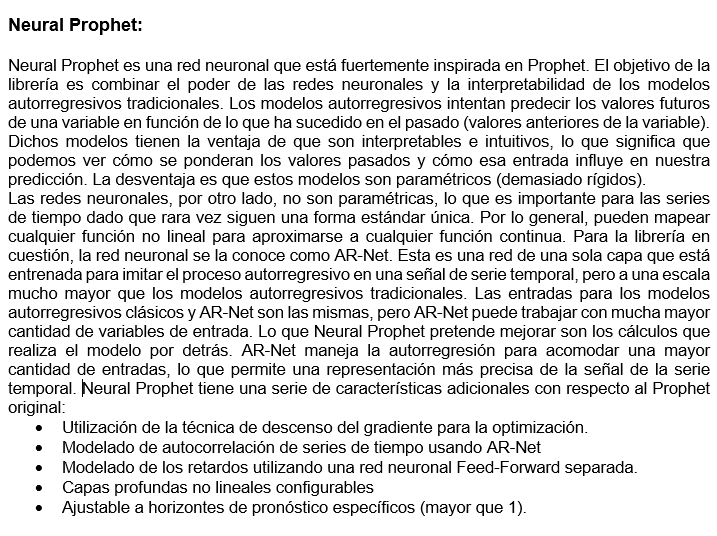

https://neuralprophet.com/how-to-guides/feature-guides/collect_predictions.html

In [ ]:
if "google.colab" in str(get_ipython()):
    # uninstall preinstalled packages from Colab to avoid conflicts
    !pip uninstall -y torch notebook notebook_shim tensorflow tensorflow-datasets prophet torchaudio torchdata torchtext torchvision
    !pip install git+https://github.com/ourownstory/neural_prophet.git # may take a while
    #!pip install neuralprophet # much faster, but may not have the latest upgrades/bugfixes

import pandas as pd
from neuralprophet import NeuralProphet, set_log_level

set_log_level("ERROR")

Found existing installation: torch 2.1.0+cu118
Uninstalling torch-2.1.0+cu118:
  Successfully uninstalled torch-2.1.0+cu118
Found existing installation: notebook 6.5.5
Uninstalling notebook-6.5.5:
  Successfully uninstalled notebook-6.5.5
Found existing installation: notebook_shim 0.2.3
Uninstalling notebook_shim-0.2.3:
  Successfully uninstalled notebook_shim-0.2.3
Found existing installation: tensorflow 2.12.0
Uninstalling tensorflow-2.12.0:
  Successfully uninstalled tensorflow-2.12.0
Found existing installation: tensorflow-datasets 4.9.3
Uninstalling tensorflow-datasets-4.9.3:
  Successfully uninstalled tensorflow-datasets-4.9.3
Found existing installation: prophet 1.1.5
Uninstalling prophet-1.1.5:
  Successfully uninstalled prophet-1.1.5
Found existing installation: torchaudio 2.1.0+cu118
Uninstalling torchaudio-2.1.0+cu118:
  Successfully uninstalled torchaudio-2.1.0+cu118
Found existing installation: torchdata 0.7.0
Uninstalling torchdata-0.7.0:
  Successfully uninstalled torchd

In [ ]:
from pandas import DataFrame
from pandas import concat
import random
from scipy import stats
import numpy as np
import pandas as pd
from math import sqrt
from numpy import concatenate
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from pandas import DataFrame
from pandas import concat
import seaborn as sn
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
# Se carga la base
url='https://raw.githubusercontent.com/braiandrago/AST/main/AirPassengers.csv'
df = pd.read_csv(url)
df['Month'] = pd.to_datetime(df['Month'])
df.head()

Month  #Passengers
0 1949-01-01          112
1 1949-02-01          118
2 1949-03-01          132
3 1949-04-01          129
4 1949-05-01          121

In [ ]:
# Se redefinen las variables para poder aplicar la librería Prophet
df = df.rename({'Month':'ds','#Passengers':'y'}, axis='columns')
df.head()

ds    y
0 1949-01-01  112
1 1949-02-01  118
2 1949-03-01  132
3 1949-04-01  129
4 1949-05-01  121

In [ ]:
# Se define la base de entrenamiento (70%) y testeo (30%)
train = df[:int(0.7*(len(df)))]
test = df[int(0.7*(len(df))):]
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44 entries, 100 to 143
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      44 non-null     datetime64[ns]
 1   y       44 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 836.0 bytes


In [ ]:
# Se inicializa y entrena el modelo
m = NeuralProphet()
metrics = m.fit(train, freq="MS")

Finding best initial lr:   0%|          | 0/207 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

In [ ]:
# Se generan las predicciones
future = m.make_future_dataframe(train,n_historic_predictions=True ,periods=44)
forecast = m.predict(future)

Predicting: 4it [00:00, ?it/s]

In [ ]:
forecast

ds     y       yhat1       trend  season_yearly
0   1949-01-01   112  109.393234  131.508698     -22.115459
1   1949-02-01   118  100.244446  129.692123     -29.447674
2   1949-03-01   132  130.549789  128.051346       2.498444
3   1949-04-01   129  125.047668  126.234772      -1.187106
4   1949-05-01   121  122.053467  124.476807      -2.423337
..         ...   ...         ...         ...            ...
139 1960-08-01  None  530.384583  485.175232      45.209373
140 1960-09-01  None  501.779388  488.508728      13.270671
141 1960-10-01  None  473.558716  491.734741     -18.176006
142 1960-11-01  None  446.100647  495.068298     -48.967640
143 1960-12-01  None  476.583405  498.294281     -21.710901

[144 rows x 5 columns]

In [ ]:
m.plot(forecast)

In [ ]:
m.plot_components(forecast)

In [ ]:
# Se grafican las predicciones y las componentes
m.plot_parameters()

In [ ]:
# Se generan las predicciones para la base de testeo
X_tst_forecast = m.predict(test)

Predicting: 4it [00:00, ?it/s]

In [ ]:
X_tst_forecast.tail(5)

ds    y       yhat1       trend  season_yearly
39 1960-08-01  606  530.384583  485.175232      45.209373
40 1960-09-01  508  501.779388  488.508728      13.270671
41 1960-10-01  461  473.558716  491.734741     -18.176006
42 1960-11-01  390  446.100647  495.068298     -48.967640
43 1960-12-01  432  476.583405  498.294281     -21.710901

In [ ]:
m.plot(X_tst_forecast)

In [ ]:
# Cálculo de las medidas de precisión
rmse = sqrt(mean_squared_error(test['y'], X_tst_forecast['yhat1']))
print('Test RMSE: %.3f' % rmse)
mse = mean_squared_error(test['y'], X_tst_forecast['yhat1'])
print('Test MSE: %.3f' % mse)
mae = mean_absolute_error(test['y'], X_tst_forecast['yhat1'])
print('Test MAE: %.3f' % mae)
r2 = r2_score(test['y'], X_tst_forecast['yhat1'])
print('Test R2: %.3f' % r2)

Test RMSE: 39.422
Test MSE: 1554.073
Test MAE: 33.649
Test R2: 0.734


**Y si adicionamos autorregresión?**

In [ ]:
 # Se inicializa y entrena el modelo
m = NeuralProphet(n_lags=5)
metrics = m.fit(train, freq="MS")

Finding best initial lr:   0%|          | 0/207 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

In [ ]:
# Se generan las predicciones para la base de testeo
X2_tst_forecast = m.predict(test)

Predicting: 6it [00:00, ?it/s]

In [ ]:
X2_tst_forecast

ds      y       yhat1         ar1       trend  season_yearly
0  1957-05-01  355.0         NaN         NaN         NaN            NaN
1  1957-06-01  422.0         NaN         NaN         NaN            NaN
2  1957-07-01  465.0         NaN         NaN         NaN            NaN
3  1957-08-01  467.0         NaN         NaN         NaN            NaN
4  1957-09-01  404.0         NaN         NaN         NaN            NaN
5  1957-10-01  347.0  387.686005  651.496399 -244.470215     -19.340174
6  1957-11-01  305.0  363.208252  657.422852 -246.293884     -47.920746
7  1957-12-01  336.0  375.137543  646.223877 -248.058777     -23.027569
8  1958-01-01  340.0  371.952728  642.617493 -249.882477     -20.782284
9  1958-02-01  318.0  354.152527  632.203674 -251.706207     -26.344950
10 1958-03-01  362.0  379.471069  626.299194 -253.353424       6.525269
11 1958-04-01  348.0  366.512756  623.728943 -255.177094      -2.039082
12 1958-05-01  363.0  359.992645  620.664062 -256.941986      -3.729427
13 1958-06-01  435.0  399.701202  632.769897 -258.765686      25.696972
14 1958-07-01  491.0  428.140289  636.874207 -260.530579      51.796658
15 1958-08-01  505.0  447.358887  662.798340 -262.354248      46.914845
16 1958-09-01  404.0  438.009003  687.538879 -264.177948      14.648080
17 1958-10-01  359.0  405.059509  690.708923 -265.942841     -19.706606
18 1958-11-01  310.0  385.970276  700.965332 -267.766541     -47.228474
19 1958-12-01  337.0  381.710144  675.205261 -269.531403     -23.963766
20 1959-01-01  360.0  393.638580  684.915955 -271.355103     -19.922245
21 1959-02-01  342.0  358.622131  658.978577 -273.178833     -27.177647
22 1959-03-01  406.0  393.368622  661.249634 -274.826019       6.945028
23 1959-04-01  396.0  389.342224  668.490662 -276.649750      -2.498669
24 1959-05-01  420.0  387.028229  668.683289 -278.414612      -3.240481
25 1959-06-01  472.0  441.369720  696.837219 -280.238312      24.770786
26 1959-07-01  548.0  470.236145  699.896423 -282.003174      52.342896
27 1959-08-01  559.0  499.645355  737.053528 -283.826904      46.418736
28 1959-09-01  463.0  486.518616  756.565186 -285.650604      15.604053
29 1959-10-01  407.0  465.803894  773.293030 -287.415436     -20.073658
30 1959-11-01  362.0  436.546082  772.315491 -289.239166     -46.530235
31 1959-12-01  405.0  438.351715  754.258057 -291.004059     -24.902285
32 1960-01-01  417.0  451.077789  762.968750 -292.827759     -19.063221
33 1960-02-01  391.0  417.523743  740.181458 -294.651428     -28.006306
34 1960-03-01  419.0  452.556000  743.243164 -296.357483       5.670312
35 1960-04-01  461.0  435.930573  735.230164 -298.181213      -1.118353
36 1960-05-01  472.0  441.966339  746.615295 -299.946075      -4.702893
37 1960-06-01  535.0  485.618439  759.840515 -301.769745      27.547653
38 1960-07-01  622.0  533.465698  786.304810 -303.534637      50.695568
39 1960-08-01  606.0  547.693604  805.149597 -305.358368      47.902367
40 1960-09-01  508.0  547.196533  841.642883 -307.182068      12.735674
41 1960-10-01  461.0  529.283997  857.203979 -308.946960     -18.972996
42 1960-11-01  390.0  485.818634  845.198059 -310.770630     -48.608803
43 1960-12-01  432.0  498.048157  832.676697 -312.535522     -22.093008

In [ ]:
# Se grafican la base de entrenamiento (punteado negro) y las predicciones (azul)
m.plot(X2_tst_forecast)

Acondicionamiento para cálculo de métricas por los lags:

In [ ]:
lag_tst_forecast=X2_tst_forecast['yhat1'].dropna()

In [ ]:
lag_test = test['y'][5:]

In [ ]:
# Cálculo de las medidas de precisión
rmse = sqrt(mean_squared_error(lag_test, lag_tst_forecast))
print('Test RMSE: %.3f' % rmse)
mse = mean_squared_error(lag_test, lag_tst_forecast)
print('Test MSE: %.3f' % mse)
mae = mean_absolute_error(lag_test, lag_tst_forecast)
print('Test MAE: %.3f' % mae)
r2 = r2_score(lag_test, lag_tst_forecast)
print('Test R2: %.3f' % r2)

Test RMSE: 48.293
Test MSE: 2332.228
Test MAE: 43.000
Test R2: 0.634


**Neural Prophet Multivariado**

**Energy price data over the 4 years from Spain**  
Fuente del dataset: https://www.kaggle.com/datasets/nicholasjhana/energy-consumption-generation-prices-and-weather

Features:    
*y*: Hourly energy price data    
*temperature*: the extra temperature column

In [ ]:
df = pd.read_csv("https://github.com/ourownstory/neuralprophet-data/raw/main/kaggle-energy/datasets/tutorial04.csv")
df.head()

ds      y  temperature
0  2015-01-01  64.92       277.00
1  2015-01-02  58.46       277.95
2  2015-01-03  63.35       278.83
3  2015-01-04  50.54       279.64
4  2015-01-05  64.89       279.05

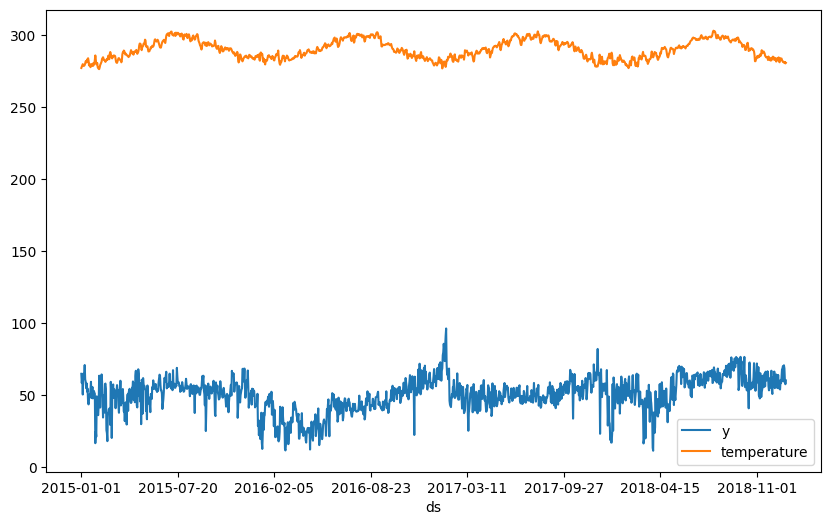

In [ ]:
fig = df.plot(x="ds", y=["y", "temperature"], figsize=(10, 6))

In [ ]:
df_train, df_val = m.split_df(df, valid_p=0.2)

print("Dataset size:", len(df))
print("Train dataset size:", len(df_train))
print("Validation dataset size:", len(df_val))

Dataset size: 1461
Train dataset size: 1171
Validation dataset size: 300


In [ ]:
m = NeuralProphet(
    # Disable trend changepoints
    n_changepoints=10,
    # Disable seasonality components
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=True,
    # Add the autogression
    n_lags=10,)

In [ ]:
# Add the new lagged regressor
m.add_lagged_regressor("temperature")

Finding best initial lr:   0%|          | 0/227 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

MAE_val   RMSE_val  Loss_val  RegLoss_val  epoch        MAE       RMSE  \
0    65.811279  82.101547  0.832046          0.0      0  65.662666  78.506699   
1    63.243412  78.938828  0.787085          0.0      1  63.281799  75.859329   
2    59.941582  74.795982  0.729411          0.0      2  60.446136  72.091469   
3    56.094425  69.993614  0.662758          0.0      3  57.816227  68.924873   
4    51.603180  64.471535  0.586144          0.0      4  53.313168  63.665764   
..         ...        ...       ...          ...    ...        ...        ...   
180   5.912579   7.373944  0.009651          0.0    180   4.786983   6.415892   
181   5.933951   7.398728  0.009716          0.0    181   4.803866   6.450181   
182   5.927746   7.391552  0.009698          0.0    182   4.807647   6.454864   
183   5.930629   7.394857  0.009706          0.0    183   4.848782   6.483561   
184   5.930101   7.394258  0.009705          0.0    184   4.796719   6.461411   

         Loss  RegLoss  
0    0.603320      0.0  
1    0.571555      0.0  
2    0.532856      0.0  
3    0.497774      0.0  
4    0.441174      0.0  
..        ...      ...  
180  0.005602      0.0  
181  0.005621      0.0  
182  0.005637      0.0  
183  0.005729      0.0  
184  0.005623      0.0  

[185 rows x 9 columns]

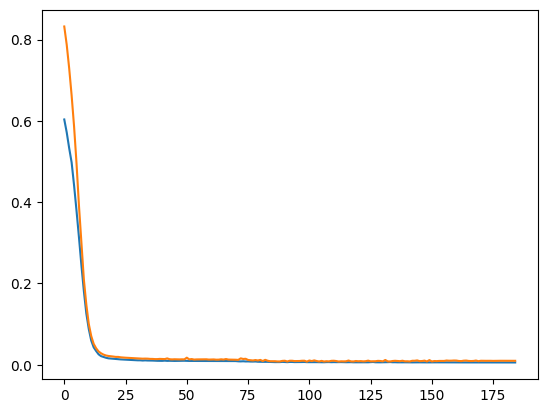

In [ ]:
metrics = m.fit(df_train, validation_df=df_val, progress="plot")
metrics

In [ ]:
forecast = m.predict(df_val)
m.plot(forecast)

Predicting: 37it [00:00, ?it/s]

In [ ]:
m.plot_components(forecast, components=["lagged_regressors"])

En la gráfica superior se observa cómo el regresor rezagado contribuye a la serie temporal resultante (forecast) y ayuda a comprender la relación entre esos regresores y la serie predicha.

In [ ]:
m.plot_parameters(components=["lagged_regressors"])

En la gráfica superior, se muestra la relevancia de los regresores rezagados.

In [ ]:
metrics

MAE_val   RMSE_val  Loss_val  RegLoss_val  epoch        MAE       RMSE  \
0    65.811279  82.101547  0.832046          0.0      0  65.662666  78.506699   
1    63.243412  78.938828  0.787085          0.0      1  63.281799  75.859329   
2    59.941582  74.795982  0.729411          0.0      2  60.446136  72.091469   
3    56.094425  69.993614  0.662758          0.0      3  57.816227  68.924873   
4    51.603180  64.471535  0.586144          0.0      4  53.313168  63.665764   
..         ...        ...       ...          ...    ...        ...        ...   
180   5.912579   7.373944  0.009651          0.0    180   4.786983   6.415892   
181   5.933951   7.398728  0.009716          0.0    181   4.803866   6.450181   
182   5.927746   7.391552  0.009698          0.0    182   4.807647   6.454864   
183   5.930629   7.394857  0.009706          0.0    183   4.848782   6.483561   
184   5.930101   7.394258  0.009705          0.0    184   4.796719   6.461411   

         Loss  RegLoss  
0    0.603320      0.0  
1    0.571555      0.0  
2    0.532856      0.0  
3    0.497774      0.0  
4    0.441174      0.0  
..        ...      ...  
180  0.005602      0.0  
181  0.005621      0.0  
182  0.005637      0.0  
183  0.005729      0.0  
184  0.005623      0.0  

[185 rows x 9 columns]

In [ ]:
metrics_test = m.test(df=df_val)

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         Loss_test         │   0.009704632684588432    │
│          MAE_val          │     5.930100917816162     │
│         RMSE_val          │     7.394257545471191     │
│       RegLoss_test        │            0.0            │
└───────────────────────────┴───────────────────────────┘

## **Librería DARTS**  

Darts es una biblioteca de Python para pronósticos en series temporales fáciles de usar. Contiene una variedad de modelos, desde clásicos como ARIMA hasta redes neuronales profundas. Todos los modelos de pronóstico se pueden usar de la misma manera, usando las funciones fit() y predict(), similares a scikit-learn.  

[Página Oficial](https://unit8co.github.io/darts/) [Fuente del Ejemplo](https://medium.com/unit8-machine-learning-publication/darts-time-series-made-easy-in-python-5ac2947a8878)

https://unit8co.github.io/darts/examples/03-FFT-examples.html

### **Exponential Smoothing**

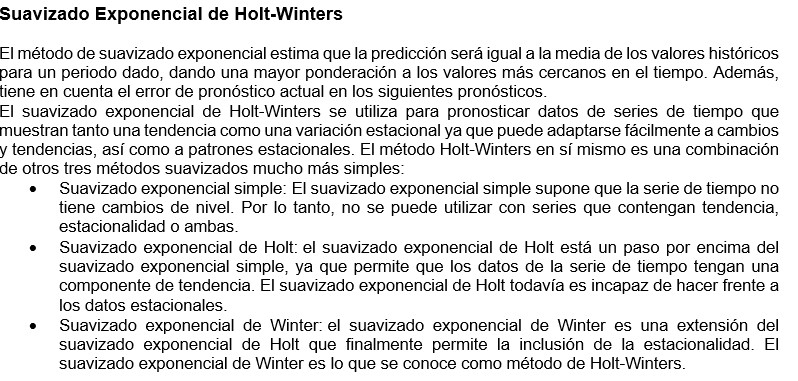

In [ ]:
pip install darts

In [ ]:
from darts import TimeSeries
from darts.models import (NaiveSeasonal,NaiveDrift,RNNModel,Prophet,ExponentialSmoothing,ARIMA,AutoARIMA,TCNModel,TransformerModel,Theta,FFT)

In [ ]:
#! pip install u8darts

In [ ]:
# Se carga la base
url='https://raw.githubusercontent.com/braiandrago/AST/main/AirPassengers.csv'
df = pd.read_csv(url)
df['Month'] = pd.to_datetime(df['Month'])
df.head()

Month  #Passengers
0 1949-01-01          112
1 1949-02-01          118
2 1949-03-01          132
3 1949-04-01          129
4 1949-05-01          121

In [ ]:
# Se redefinen las variables
df = df.rename({'Month':'ds','#Passengers':'y'}, axis='columns')
df.head()

ds    y
0 1949-01-01  112
1 1949-02-01  118
2 1949-03-01  132
3 1949-04-01  129
4 1949-05-01  121

In [ ]:
train = df[:int(0.7*(len(df)))]
test = df[int(0.7*(len(df))):]

In [ ]:
# Se genera la base de entrenamiento, testeo y la base completa
train2 = TimeSeries.from_dataframe(train, 'ds', 'y')
test2 = TimeSeries.from_dataframe(test, 'ds', 'y')
df2 = TimeSeries.from_dataframe(df, 'ds', 'y')

In [ ]:
# Se inicializa, se entrena el modelo y se generan las predicciones
model = ExponentialSmoothing()
model.fit(train2)
prediction = model.predict(44)

In [ ]:
# Previsualización de las predicciones
prediction

<TimeSeries (DataArray) (ds: 44, component: 1, sample: 1)>
array([[[351.23966609]],

       [[403.30818522]],

       [[439.93678134]],

       [[426.79964473]],

       [[375.9727064 ]],

       [[329.10915969]],

       [[295.90066062]],

       [[333.33115381]],

       [[343.40514284]],

       [[331.80911139]],

...

       [[440.25786592]],

       [[430.08702369]],

       [[434.94390426]],

       [[487.01242339]],

       [[523.64101951]],

       [[510.5038829 ]],

       [[459.67694457]],

       [[412.81339785]],

       [[379.60489879]],

       [[417.03539198]]])
Coordinates:
  * ds         (ds) datetime64[ns] 1957-05-01 1957-06-01 ... 1960-12-01
  * component  (component) object 'y'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [ ]:
# Previsualización de la base de testeo
test2

<TimeSeries (DataArray) (ds: 44, component: 1, sample: 1)>
array([[[355.]],

       [[422.]],

       [[465.]],

       [[467.]],

       [[404.]],

       [[347.]],

       [[305.]],

       [[336.]],

       [[340.]],

       [[318.]],

...

       [[419.]],

       [[461.]],

       [[472.]],

       [[535.]],

       [[622.]],

       [[606.]],

       [[508.]],

       [[461.]],

       [[390.]],

       [[432.]]])
Coordinates:
  * ds         (ds) datetime64[ns] 1957-05-01 1957-06-01 ... 1960-12-01
  * component  (component) object 'y'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

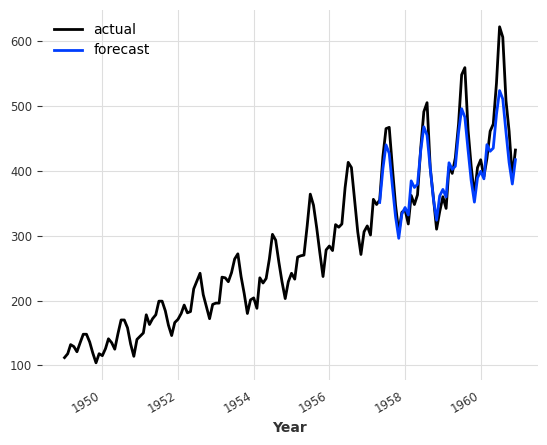

In [ ]:
# Se grafican la base completa y las predicciones
df2.plot(label='actual')
prediction.plot(label='forecast', lw=2)
plt.legend()
plt.xlabel('Year');

In [ ]:
# calculate RMSE
rmse = sqrt(mean_squared_error(test['y'], prediction.pd_dataframe()))
print('Test RMSE: %.3f' % rmse)
mse = mean_squared_error(test['y'], prediction.pd_dataframe())
print('Test MSE: %.3f' % mse)
mae = mean_absolute_error(test['y'], prediction.pd_dataframe())
print('Test MAE: %.3f' % mae)
r2 = r2_score(test['y'], prediction.pd_dataframe())
print('Test R2: %.3f' % r2)

Test RMSE: 33.629
Test MSE: 1130.927
Test MAE: 24.876
Test R2: 0.806


### **AutoARIMA**

In [ ]:
# Se inicializa, se entrena el modelo y se generan las predicciones
model_aarima = AutoARIMA(random_state = 10)
model_aarima.fit(train2)
prediction = model_aarima.predict(44)

In [ ]:
# Previsualización de las predicciones
prediction

<TimeSeries (DataArray) (ds: 44, component: 1, sample: 1)>
array([[[323.39487215]],

       [[324.80742912]],

       [[325.46490092]],

       [[325.77091986]],

       [[325.91335575]],

       [[325.97965226]],

       [[326.01050983]],

       [[326.02487243]],

       [[326.03155747]],

       [[326.03466901]],

...

       [[326.0373783 ]],

       [[326.0373783 ]],

       [[326.0373783 ]],

       [[326.0373783 ]],

       [[326.0373783 ]],

       [[326.0373783 ]],

       [[326.0373783 ]],

       [[326.0373783 ]],

       [[326.0373783 ]],

       [[326.0373783 ]]])
Coordinates:
  * ds         (ds) datetime64[ns] 1957-05-01 1957-06-01 ... 1960-12-01
  * component  (component) object 'y'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

Text(0.5, 0, 'Year')

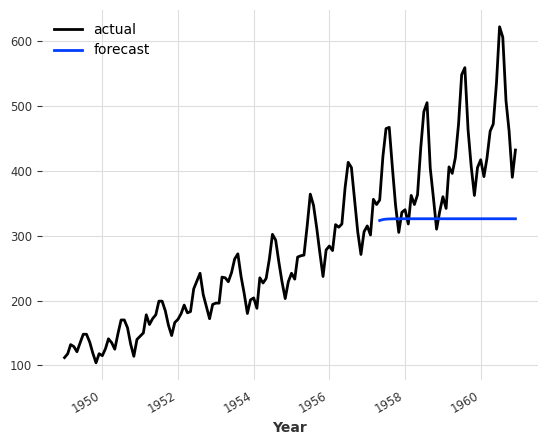

In [ ]:
# Se grafican la base completa y las predicciones
df2.plot(label='actual')
prediction.plot(label='forecast', lw=2)
plt.legend()
plt.xlabel('Year')

In [ ]:
# Cálculo de las medidas de precisión
rmse = sqrt(mean_squared_error(test['y'], prediction.pd_dataframe()))
print('Test RMSE: %.3f' % rmse)
mse = mean_squared_error(test['y'], prediction.pd_dataframe())
print('Test MSE: %.3f' % mse)
mae = mean_absolute_error(test['y'], prediction.pd_dataframe())
print('Test MAE: %.3f' % mae)
r2 = r2_score(test['y'], prediction.pd_dataframe())
print('Test R2: %.3f' % r2)

Test RMSE: 122.024
Test MSE: 14889.769
Test MAE: 97.192
Test R2: -1.548


### **RNN (LSTM)**

In [ ]:
# Se normaliza la base
from darts.dataprocessing.transformers import Scaler
transformer = Scaler()
train_transformed = transformer.fit_transform(train2)
test_transformed = transformer.transform(test2)
series_transformed = transformer.transform(df2)

In [ ]:
# Se inicializa, se entrena el modelo y se generan las predicciones
model_RNN = RNNModel( model='LSTM',
    input_chunk_length=10,
    output_chunk_length=1,
    hidden_dim=25,
    n_rnn_layers=2,
    dropout=0.2,
    batch_size=32,
    n_epochs=100,
    optimizer_kwargs={'lr': 1e-3},
    log_tensorboard=True,
    random_state=42)
model_RNN.fit(train_transformed)

Training: 0it [00:00, ?it/s]

RNNModel(model=LSTM, hidden_dim=25, n_rnn_layers=2, dropout=0.2, training_length=24, input_chunk_length=10, output_chunk_length=1, batch_size=32, n_epochs=100, optimizer_kwargs={'lr': 0.001}, log_tensorboard=True, random_state=42)

In [ ]:
prediction = model_RNN.predict(44)

Predicting: 0it [00:00, ?it/s]

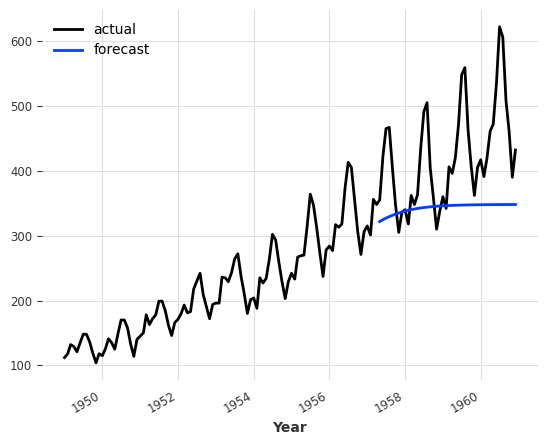

In [ ]:
# Se grafican la base completa y las predicciones
transformer.inverse_transform(series_transformed).plot(label='actual')
transformer.inverse_transform(prediction).plot(label='forecast', lw=2)
plt.legend()
plt.xlabel('Year');

In [ ]:
# Previsualización de las predicciones
transformer.inverse_transform(prediction)

<TimeSeries (DataArray) (ds: 44, component: 1, sample: 1)>
array([[[321.74323353]],

       [[324.65563451]],

       [[327.07331354]],

       [[329.29263695]],

       [[331.34154442]],

       [[333.21671444]],

       [[334.91625242]],

       [[336.44491763]],

       [[337.81232902]],

       [[339.03062557]],

...

       [[347.75600371]],

       [[347.79795725]],

       [[347.8346682 ]],

       [[347.86678975]],

       [[347.89489414]],

       [[347.9194826 ]],

       [[347.94099408]],

       [[347.9598129 ]],

       [[347.97627557]],

       [[347.99067664]]])
Coordinates:
  * ds         (ds) datetime64[ns] 1957-05-01 1957-06-01 ... 1960-12-01
  * component  (component) object 'y'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [ ]:
# Cálculo de las medidas de precisión
rmse = sqrt(mean_squared_error(test['y'], prediction.pd_dataframe()))
print('Test RMSE: %.3f' % rmse)
mse = mean_squared_error(test['y'], prediction.pd_dataframe())
print('Test MSE: %.3f' % mse)
mae = mean_absolute_error(test['y'], prediction.pd_dataframe())
print('Test MAE: %.3f' % mae)
r2 = r2_score(test['y'], prediction.pd_dataframe())
print('Test R2: %.3f' % r2)

Test RMSE: 427.190
Test MSE: 182491.051
Test MAE: 420.295
Test R2: -30.227


### **FFT (Fast Fourier Transform)**
[Artículo sobre la Transformada de Fourier](https://medium.com/@khairulomar/deconstructing-time-series-using-fourier-transform-e52dd535a44e)

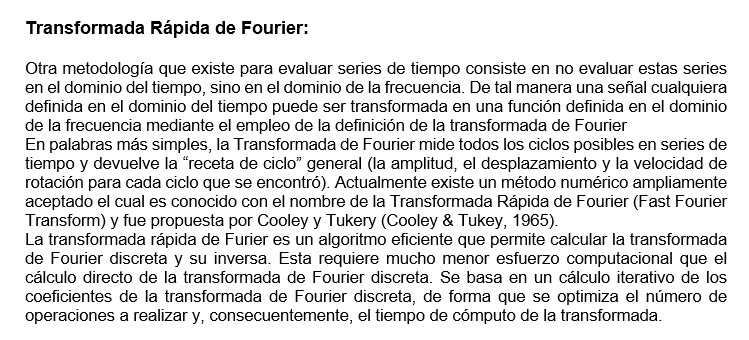

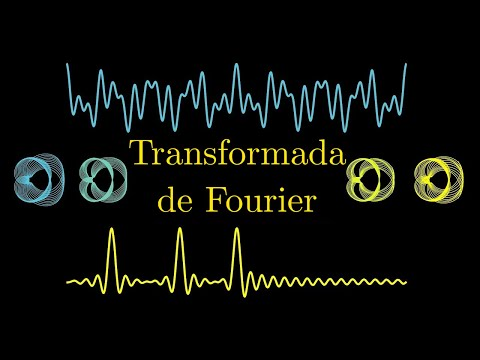

In [ ]:
YouTubeVideo('h4PTucW3Rm0')
# https://www.youtube.com/watch?v=h4PTucW3Rm0

In [ ]:
# Se inicializa, se entrena el modelo y se generan las predicciones
model_FFT = FFT()
model_FFT.fit(train2)
prediction = model_FFT.predict(44)

In [ ]:
# Previsualización de las predicciones
prediction

<TimeSeries (DataArray) (ds: 44, component: 1, sample: 1)>
array([[[229.98827499]],

       [[209.84245695]],

       [[189.32751042]],

       [[170.86356052]],

       [[156.31605819]],

       [[146.44435717]],

       [[140.72204769]],

       [[137.5841489 ]],

       [[135.01488411]],

       [[131.27729662]],

...

       [[177.84484144]],

       [[166.90079717]],

       [[160.31941174]],

       [[160.44128806]],

       [[167.68321675]],

       [[180.37781883]],

       [[195.24140872]],

       [[208.34116386]],

       [[216.27720417]],

       [[217.22397943]]])
Coordinates:
  * ds         (ds) datetime64[ns] 1957-05-01 1957-06-01 ... 1960-12-01
  * component  (component) object 'y'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

Text(0.5, 0, 'Year')

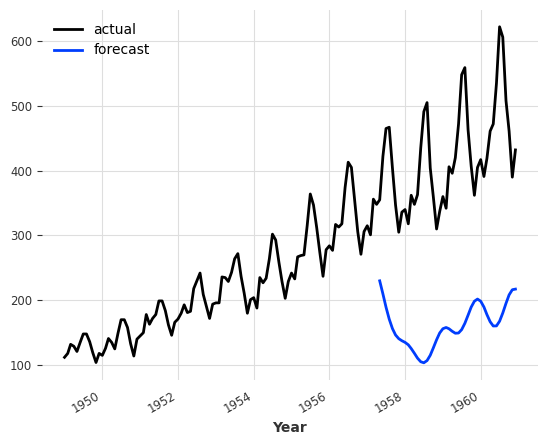

In [ ]:
# Se grafican la base completa y las predicciones
df2.plot(label='actual')
prediction.plot(label='forecast', lw=2)
plt.legend()
plt.xlabel('Year')

In [ ]:
# Cálculo de las medidas de precisión
rmse = sqrt(mean_squared_error(test['y'], prediction.pd_dataframe()))
print('Test RMSE: %.3f' % rmse)
mse = mean_squared_error(test['y'], prediction.pd_dataframe())
print('Test MSE: %.3f' % mse)
mae = mean_absolute_error(test['y'], prediction.pd_dataframe())
print('Test MAE: %.3f' % mae)
r2 = r2_score(test['y'], prediction.pd_dataframe())
print('Test R2: %.3f' % r2)

Test RMSE: 271.310
Test MSE: 73609.224
Test MAE: 259.851
Test R2: -11.596


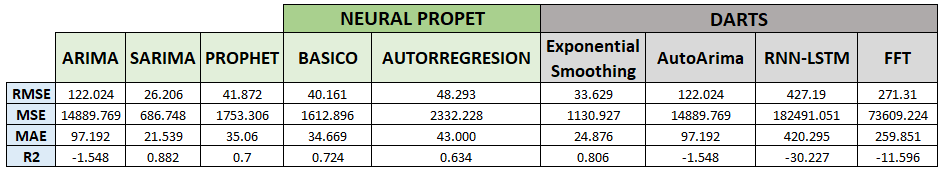